Things Added:
1. In this version, I preprocess data using pipeline to be more efficient [here](https://towardsdatascience.com/clean-efficient-data-pipelines-with-pythons-sklearn-2472de04c0ea)
2. In this version, I added outlier/abnormaly detection for features in order to improve the performance


Things Learned:
[Reference](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)
1. For imbalanced data, fit the model either with the data that were undersample and oversample, but test it on ORIGINAL testing data NOT on undersample/oversample testing data
2. Techiques to visualize high-dimension data. Ex t-SNE, PCA and Truncate SVD
3. If we want to implement cross validation, remember to oversample or undersample your training data DURING cross-validation, not BEFORE!
4. Don't use accuracy score as a metric with imbalanced datasets (will be usually high and misleading), instead use f1-score, precision/recall score or confusion matrix


Questions:
1. The process to deal with imbalanced data:

a. Split original data to train_original and test_original and then undersample/oversample train_original and split the undersampled/oversampled train_original to train_undersample and test_undersample. Use train_undersample to train model and test on test_original

b. Split original data to train and test. Oversample train and build the model. Test model on original test

2. How to interpret ROC/learning curve and how to improve model performance (f1, precision?)

3. How to remove outlier in pipeline for SMOTE?

In [7]:
!pip install kaggle
!pip install feature_engine
!pip install category_encoders
!pip install catboost
!pip install shap

In [8]:
!echo '{"username":"sijielily","key":"f9f86a65ad9311c058ef539dcc0d9e16"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: creditcard.csv          


In [40]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.impute import SimpleImputer
from feature_engine.imputation import CategoricalImputer
from collections import Counter
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from scipy.stats import uniform, truncnorm, randint
import category_encoders as ce
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot
from imblearn.pipeline import Pipeline as pipeline
from imblearn.pipeline import make_pipeline
import itertools
import shap
import pickle
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

#1.1 Read Data and get dimension

In [10]:
train = pd.read_csv('creditcard.csv')
print('The numbers of rows in train is %d and number of feature is %d'%(train.shape[0],train.shape[1]))

The numbers of rows in train is 284807 and number of feature is 31


In [11]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [13]:
train_target = pd.DataFrame(train['Class'])
train_target.reset_index(drop=True,inplace=True)
train = train[train.columns[~train.columns.isin(['Class'])]]

### 1.1.1 Check missing values

In [14]:
print('Checking null values in features')
train_null = train.isnull().sum()
train_null = train_null[train_null > 0].to_frame()
train_null.reset_index(inplace=True)
train_null.columns = ['Feature','number_of_missing']
train_null['Percentage_of_missing_values'] = train_null['number_of_missing']/train_null.shape[0]
train_null.sort_values(by = ['Percentage_of_missing_values'],ascending = False, inplace=True)
display(train_null)

Checking null values in features


,Feature,number_of_missing,Percentage_of_missing_values


#2.1 Split original data to train and test

In [15]:
X_train_original,X_test_original,y_train_original,y_test_original = train_test_split(train,train_target,test_size = 0.3,random_state= 0)
print('Train features has %s rows and %s columns' %(X_train_original.shape[0],X_train_original.shape[1]))
print('Train target has %s instances' % (len(y_train_original)))
print('Test features has %s rows and %s columns' %(X_test_original.shape[0],X_test_original.shape[1]))
print('Test target has %s instances' % (len(y_test_original)))

Train features has 199364 rows and 30 columns
Train target has 199364 instances
Test features has 85443 rows and 30 columns
Test target has 85443 instances


# 3.1 Data Exploration - Find feature distribution and test for normality
### 3.1.1 Calculate skewness of the features

In [16]:
skewness = X_train_original.apply(lambda x: skew(x,nan_policy = 'omit')) #ignore na value
skewness.sort_values(ascending=False)

Amount    13.632135
V28        8.963773
V21        3.711025
V6         1.252585
V10        1.224283
V4         0.662671
V26        0.575757
V9         0.564996
V11        0.329533
V19        0.110208
V13        0.064478
Time      -0.034377
V22       -0.214418
V18       -0.267298
V15       -0.313887
V25       -0.399954
V24       -0.548976
V5        -0.587249
V20       -0.746282
V7        -1.029449
V16       -1.106320
V14       -1.926809
V12       -2.158061
V3        -2.227623
V27       -2.967345
V1        -3.283298
V17       -3.913927
V2        -4.433047
V23       -6.391644
V8        -9.079406
dtype: float64

### 3.1.2 Test normality of the numerical features
Most of the features are not normally distributed.

Things Learned:
1. Normalize data before PCA [here](https://stats.stackexchange.com/questions/69157/why-do-we-need-to-normalize-data-before-principal-component-analysis-pca)


In [17]:
statistics_list = []
p_value_list = []

for i in range(0,len(list(X_train_original.columns))):
    feature=X_train_original.columns[i]
    stat,p_value = stats.normaltest(X_train_original[feature],nan_policy = 'omit')#ignore na value
    statistics_list.append(stat)
    p_value_list.append(p_value)

normality_test = pd.DataFrame(columns = ['Feature','Test-statistics','P_value','Decision'])
normality_test['Feature'] = list(X_train_original.columns)
normality_test['Test-statistics'] = statistics_list
normality_test['P_value'] = p_value_list
normality_test['Decision'] = np.where(normality_test['P_value'] > 0.5, 'Normal','Not Normal')
normality_test

,Feature,Test-statistics,P_value,Decision
0,Time,677579.960345,0.000000e+00,Not Normal
1,V1,154914.102882,0.000000e+00,Not Normal
2,V2,201943.584757,0.000000e+00,Not Normal
3,V3,119229.944534,0.000000e+00,Not Normal
4,V4,23755.308642,0.000000e+00,Not Normal
5,V5,75410.935151,0.000000e+00,Not Normal
6,V6,68630.672233,0.000000e+00,Not Normal
7,V7,102486.775881,0.000000e+00,Not Normal
8,V8,303954.716486,0.000000e+00,Not Normal
9,V9,27471.644374,0.000000e+00,Not Normal


### 3.1.3 Scale unscaled features 
Since most of features are already scaled, we should scale the features that are left, which are Time and Amount. 

In order to have less outlier influence, let's use robust scaler

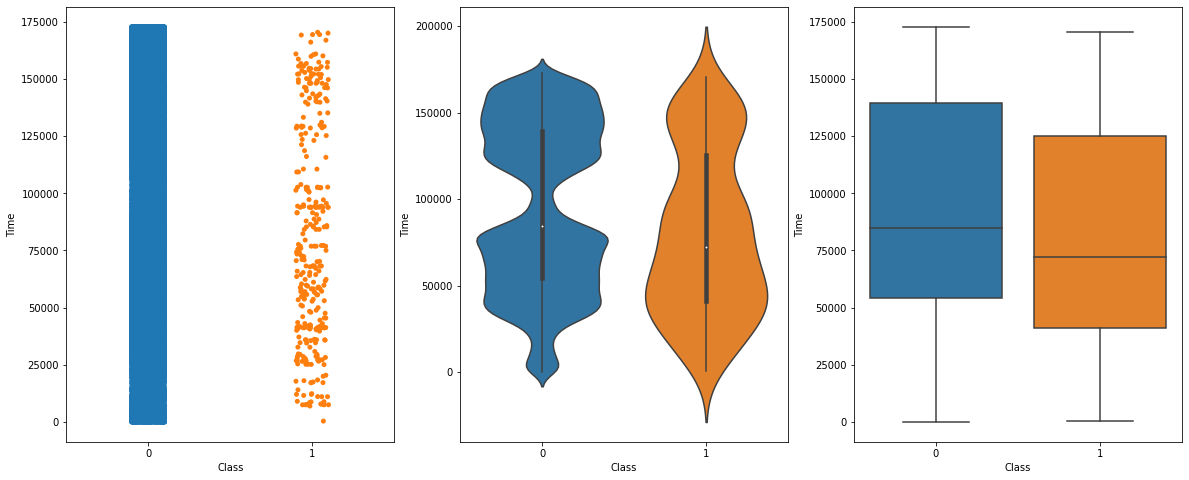

In [18]:
figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(y_train_original.Class, x = 'Class', y=X_train_original.Time, ax = ax[0])
sns.violinplot(y_train_original.Class, x = 'Class', y=X_train_original.Time, ax = ax[1])
sns.boxplot(y_train_original.Class, x = 'Class', y=X_train_original.Time, whis = 99, ax = ax[2])
plt.show()

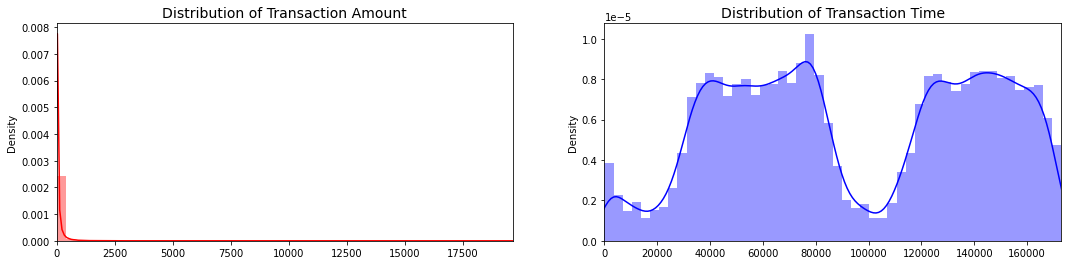

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = X_train_original['Amount'].values
time_val = X_train_original['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [20]:
#unscaled_features = ['Amount','Time']
#scaler = make_column_transformer((unscaled_features, make_pipeline(RobustScaler())), remainder = 'passthrough')
robust_sc = RobustScaler()
robust_sc.fit(X_train_original[['Amount','Time']])
X_train_original[['Amount','Time']] = robust_sc.transform(X_train_original[['Amount','Time']])
X_train_original.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
161145,0.343717,-0.132066,0.107044,-0.650588,-0.996032,1.814333,1.740740,0.496852,0.633016,0.017181,-0.362707,0.527911,0.505396,-0.742107,0.492430,-0.163585,-0.950404,0.262987,-1.760767,-0.939037,-0.062612,-0.062489,0.005292,0.251519,-2.466810,-0.889690,0.337462,0.306395,0.074817,0.359933
204520,0.594843,2.125994,0.014207,-1.514760,0.115021,0.598510,-0.333235,0.199289,-0.264353,0.384111,0.028747,-1.208334,0.838156,1.511476,-0.042076,-0.002894,0.080270,-0.658905,-0.747678,0.431762,-0.086076,-0.329368,-0.788150,0.267730,0.066122,-0.135785,0.203841,-0.068267,-0.057678,-0.278326
182659,0.479584,-0.086694,0.166240,1.573127,0.687266,0.222359,1.102606,1.575093,-1.098608,0.763887,1.404677,1.346697,0.140822,0.159637,-1.147153,0.664997,-0.133032,-1.267675,0.818995,0.405276,0.052960,0.015324,1.063663,-0.410841,0.722723,-0.171733,-0.613543,-1.201571,-1.139931,2.058946
25117,-0.599866,1.352339,-0.534984,0.555143,-0.629355,-1.144170,-0.852967,-0.642128,-0.032659,-0.654482,0.619206,0.103615,-1.067971,-1.227629,0.197196,1.151364,0.846905,0.710309,-1.963506,0.130406,-0.066712,-0.014814,-0.180379,0.178112,0.347720,0.151810,-0.404361,0.013746,0.016152,-0.222995
227642,0.710242,-1.526760,0.647782,0.615391,-0.561114,0.836950,-0.514251,0.984325,-0.097430,-0.062634,-1.033567,-0.706095,-0.612354,-0.336939,-1.384147,0.314279,0.552201,0.512582,0.370183,-0.163736,-0.073333,-0.221533,-0.393158,-0.214990,0.588447,0.679496,0.518434,0.065022,0.147294,0.944668


Use scaler from train to transform test data

In [21]:
X_test_original[['Amount','Time']] = robust_sc.transform(X_test_original[['Amount','Time']])
X_test_original.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
183484,0.483375,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,-1.118863,0.202647,1.145965,-1.802360,-0.247178,-0.060945,0.846606,0.379454,0.847262,0.186409,-0.207098,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0.250243
255448,0.852048,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,-0.854776,-0.620458,-0.806471,-0.770837,-0.108158,0.258964,0.492095,-0.148516,-0.148099,-0.096502,-0.271537,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,-0.278326
244749,0.796138,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,-1.726259,-0.736771,-1.516835,0.348343,0.041437,0.732681,-1.136766,0.816653,-1.578951,0.419835,0.701399,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,1.028778
63919,-0.395578,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,1.551682,0.435125,-0.336022,0.278965,1.812232,0.080001,0.116347,0.291818,0.106228,-0.987790,0.810408,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,3.976088
11475,-0.759721,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,0.664531,-3.282511,0.409266,1.252202,-0.868774,0.214387,1.878003,-1.906559,0.263854,-0.126871,-0.139436,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,-0.236341


# 4.1 Data Exploration - Find target variable distribution

### 4.1.2 Quick glance of skewed data

Notice that our original target variable is high imbalanced. Most of the transactions are non-fraud. If we use this imbalanced data as the base for our predictive models, we might get misleading results since the model will "assume" that most of transcations are not fraud instead of detecting patterns and then giving signs of frauds. Later I will perform oversample/undersample technique to transform data into balanced data

In [22]:
default = y_train_original[y_train_original['Class'] == 1]
nondefault = y_train_original[y_train_original['Class'] == 0]
# The classes are heavily skewed we need to solve this issue later.
print('There are', nondefault.shape[0], 'nonfraud cases')
print('No Frauds', round(nondefault.shape[0]/y_train_original.shape[0] * 100,2), '% of the dataset')
print('There are', default.shape[0], 'fraud cases')
print('Frauds', round(default.shape[0]/y_train_original.shape[0] * 100,2), '% of the dataset')


There are 199019 nonfraud cases
No Frauds 99.83 % of the dataset
There are 345 fraud cases
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

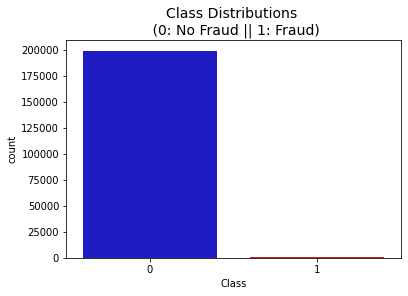

In [23]:
colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=y_train_original, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

# 5.1 Data Exploration - Correlation



### 5.1 Correlation matrix of imbalanced data - Don't use for reference

Note: Correlation matrix will be affected by the highly imblanced data. In order to have the unbiased insight, we need to use the data after undersampling to find the correlation matrix 

Text(0.5, 1.0, "Imbalanced Correlation Heatmap \n (Don't use for reference)")

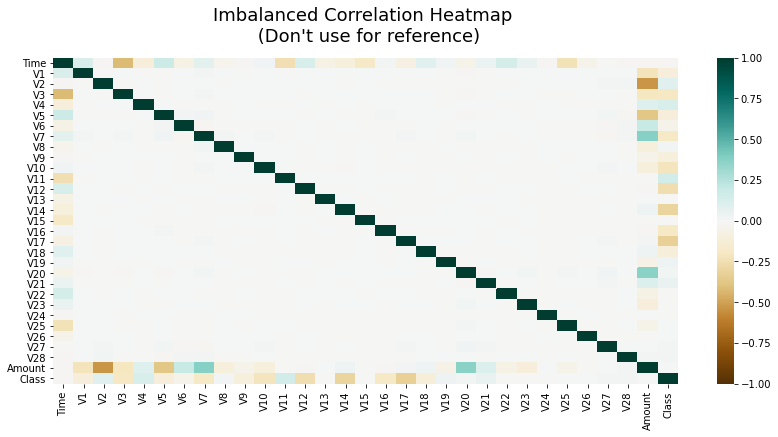

In [24]:
corr_train = pd.concat([X_train_original,y_train_original], axis=1)
corr_matrix = corr_train.corr()
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot= False, cmap='BrBG')
heatmap.set_title("Imbalanced Correlation Heatmap \n (Don't use for reference)", fontdict={'fontsize':18}, pad=16)

### 5.2 Correlation matrix of balanced data - Use for Reference

Oversample data by SMOTE to make the data balanced 

In [25]:
print("Before overSampling, counts of label '1': {}".format(y_train_original[y_train_original['Class'] == 1].shape[0])) 
print("Before overSampling, counts of label '0': {} \n".format(y_train_original[y_train_original['Class'] == 0].shape[0])) 
oversample = SMOTE(sampling_strategy = 'minority')
X_train_sampled,y_train_sampled = oversample.fit_resample(X_train_original,y_train_original)
print('After overSampling, the shape of train_X: {}'.format(X_train_sampled.shape)) 
print('After overSampling, the shape of train_y: {} \n'.format(y_train_sampled.shape)) 
print("After overSampling, counts of label '1': {}".format(sum(y_train_sampled == 1))) 
print("After overSampling, counts of label '0': {}".format(sum(y_train_sampled == 0)))

X_train_sampled = pd.DataFrame(X_train_sampled,columns = X_train_original.columns)
y_train_sampled = pd.DataFrame(y_train_sampled,columns = y_train_original.columns)

Before overSampling, counts of label '1': 345
Before overSampling, counts of label '0': 199019 

After overSampling, the shape of train_X: (398038, 30)
After overSampling, the shape of train_y: (398038,) 

After overSampling, counts of label '1': 199019
After overSampling, counts of label '0': 199019


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


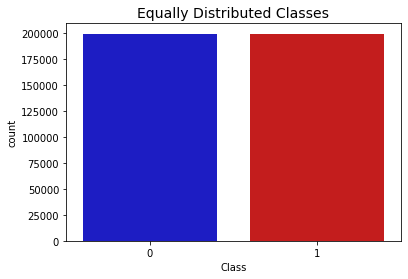

In [26]:
print('Distribution of the Classes in the subsample dataset')
print(y_train_sampled['Class'].value_counts()/len(y_train_sampled))
sns.countplot('Class', data=y_train_sampled, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Show correlation matrix of balanced data

* Negative Correlation: V3, V9, V10, V12, V14, V16 and V17 are negatively correlated with the target variable
* Positive Correlation: V2, V4, V11 are positively correlated with the target variable
* Inter-correlated Features: For the top features, they are highly correlated with each other   





The top features correlated to target variables are below
Index(['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17'], dtype='object')


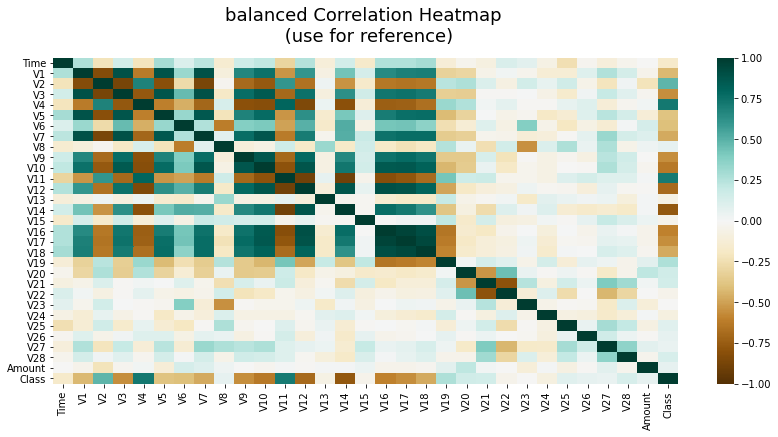

In [27]:
sampled_df = pd.concat([X_train_sampled,y_train_sampled], axis=1)
corr_matrix = sampled_df.corr()
plt.figure(figsize=(14, 6))
top_features_target = corr_matrix.index[abs(corr_matrix["Class"])>0.5].drop('Class')
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot= False, cmap='BrBG')
heatmap.set_title("balanced Correlation Heatmap \n (use for reference)", fontdict={'fontsize':18}, pad=16)
print('The top features correlated to target variables are below')
print(top_features_target)

#6.1 Data Exploration - Anomaly Detection

There are different ways to detect outlier. [here](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)

Here I use the Interquartile Range Method:
1. Visualize distribution of key features
2. Determine the threshold
3. Conditional dropping outliers
4. Visualize after dropping

Based on the heatmap above, we know that there are nine features that are most correlated with the target

In [28]:
top_features_target

Index(['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17'], dtype='object')

Text(0.5, 1.0, 'V11 vs. Class \n (Positive Correlation))')

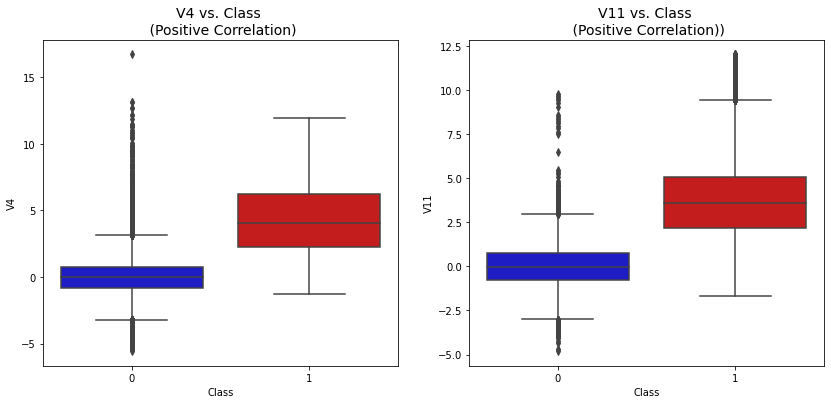

In [29]:
#Features with highest positive correlation with target
fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1,figsize = (14,6))#adjust size of the subplot canvas
fig.subplots_adjust(hspace=0.5)#adjust the vertical space between subplots

sns.boxplot(x="Class", y="V4", data=sampled_df, palette=colors, ax=ax1)
ax1.set_title('V4 vs. Class \n (Positive Correlation)', fontsize=14)

sns.boxplot(x="Class", y="V11", data=sampled_df, palette=colors, ax=ax2)
ax2.set_title('V11 vs. Class \n (Positive Correlation))', fontsize=14)


Text(0.5, 1.0, 'V11 Distribution \n (Nonfraud Transactions)')

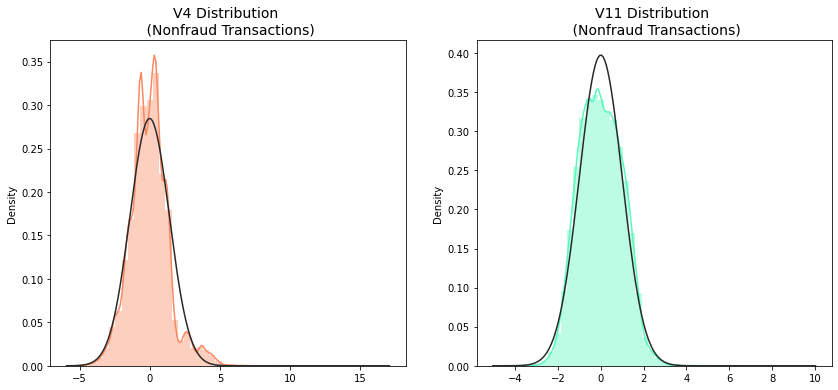

In [30]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 6))

v4_fraud_dist = sampled_df['V4'].loc[sampled_df['Class'] == 0].values
sns.distplot(v4_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V4 Distribution \n (Nonfraud Transactions)', fontsize=14)

v11_fraud_dist = sampled_df['V11'].loc[sampled_df['Class'] == 0].values
sns.distplot(v11_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V11 Distribution \n (Nonfraud Transactions)', fontsize=14)

Text(0.5, 1.0, 'V17 vs. Class \n (Negative Correlation)')

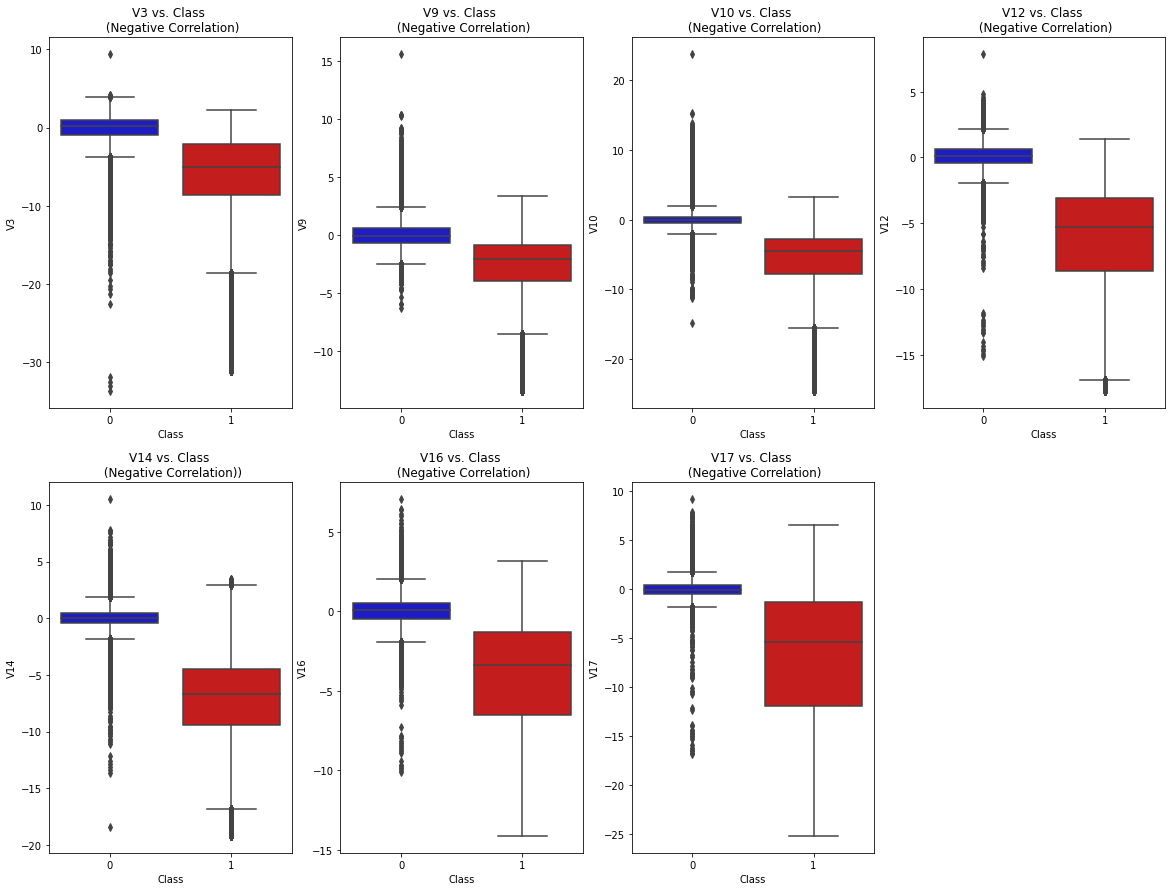

In [31]:
#features with highest negative correlation
plt.figure(figsize=(20,15))

plt.subplot(2,4,1)
sns.boxplot(x="Class", y="V3", data=sampled_df, palette=colors)
plt.title('V3 vs. Class \n (Negative Correlation)')

plt.subplot(2,4,2)
sns.boxplot(x="Class", y="V9", data=sampled_df, palette=colors)
plt.title('V9 vs. Class \n (Negative Correlation)')

plt.subplot(2,4,3)
sns.boxplot(x="Class", y="V10", data=sampled_df, palette=colors)
plt.title('V10 vs. Class \n (Negative Correlation)')

plt.subplot(2,4,4)
sns.boxplot(x="Class", y="V12", data=sampled_df, palette=colors)
plt.title('V12 vs. Class \n (Negative Correlation)')

plt.subplot(2,4,5)
sns.boxplot(x="Class", y="V14", data=sampled_df, palette=colors)
plt.title('V14 vs. Class \n (Negative Correlation))')

plt.subplot(2,4,6)
sns.boxplot(x="Class", y="V16", data=sampled_df, palette=colors)
plt.title('V16 vs. Class \n (Negative Correlation)')

plt.subplot(2,4,7)
sns.boxplot(x="Class", y="V17", data=sampled_df, palette=colors)
plt.title('V17 vs. Class \n (Negative Correlation)')

Text(0.5, 1.0, 'V14 Distribution Nonfraud Transactions)')

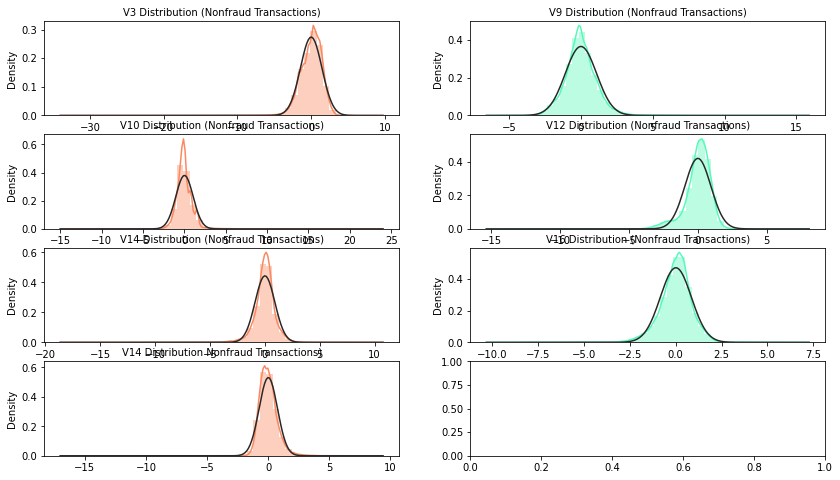

In [32]:
f, ax = plt.subplots(4,2, figsize=(14, 8))
fig.subplots_adjust(hspace=8)

v3_fraud_dist = sampled_df['V3'].loc[sampled_df['Class'] == 0].values
sns.distplot(v3_fraud_dist,ax=ax[0,0], fit=norm, color='#FB8861')
ax[0,0].set_title('V3 Distribution (Nonfraud Transactions)', fontsize=10)

v10_fraud_dist = sampled_df['V10'].loc[sampled_df['Class'] == 0].values
sns.distplot(v10_fraud_dist,ax=ax[1,0], fit=norm, color='#FB8861')
ax[1,0].set_title('V10 Distribution (Nonfraud Transactions)', fontsize=10)

v9_fraud_dist = sampled_df['V9'].loc[sampled_df['Class'] == 0].values
sns.distplot(v9_fraud_dist,ax=ax[0,1], fit=norm, color='#56F9BB')
ax[0,1].set_title('V9 Distribution (Nonfraud Transactions)', fontsize=10)

v12_fraud_dist = sampled_df['V12'].loc[sampled_df['Class'] == 0].values
sns.distplot(v12_fraud_dist,ax=ax[1,1], fit=norm, color='#56F9BB')
ax[1,1].set_title('V12 Distribution (Nonfraud Transactions)', fontsize=10)

v14_fraud_dist = sampled_df['V14'].loc[sampled_df['Class'] == 0].values
sns.distplot(v14_fraud_dist,ax=ax[2,0], fit=norm, color='#FB8861')
ax[2,0].set_title('V14 Distribution (Nonfraud Transactions)', fontsize=10)

v16_fraud_dist = sampled_df['V16'].loc[sampled_df['Class'] == 0].values
sns.distplot(v16_fraud_dist,ax=ax[2,1], fit=norm, color='#56F9BB')
ax[2,1].set_title('V16 Distribution (Nonfraud Transactions)', fontsize=10)

v17_fraud_dist = sampled_df['V17'].loc[sampled_df['Class'] == 0].values
sns.distplot(v17_fraud_dist,ax=ax[3,0], fit=norm, color='#FB8861')
ax[3,0].set_title('V14 Distribution Nonfraud Transactions)', fontsize=10)

### 6.1.1 Remove smallest value or largest value
* Q1 represents the 1st quartile/25th percentile of the data.
* Q2 represents the 2nd quartile/median/50th percentile of the data.
* Q3 represents the 3rd quartile/75th percentile of the data.
* (Q1–1.5*IQR) represent the smallest value in the data set and (Q3+1.5*IQR) represnt the largest value in the data set

In [33]:
def iqr_outliers(df, features):
    for i in features:
        fraud = df[i].loc[df['Class'] == 1].values
        q1 = np.percentile(fraud, 25)
        q3 = np.percentile(fraud, 75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        df = df.drop(df[ (df[i] > Upper_tail) | (df[i] < Lower_tail)].index)
        outliers = [x for x in fraud if x < Lower_tail or x > Upper_tail]
        print("In fraud case, number of outliers for feature " + i + " is {}".format(len(outliers)))
        print("In fraud case, outliers for feature " + i + ' are {}'.format(outliers))
    
        nonfraud = df[i].loc[df['Class'] == 0].values
        q1 = np.percentile(fraud, 25)
        q3 = np.percentile(fraud, 75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        df = df.drop(df[ (df[i] > Upper_tail) | (df[i] < Lower_tail)].index)
        outliers = [x for x in fraud if x < Lower_tail or x > Upper_tail]
        print("In fraud case, number of outliers for feature " + i + " is {}".format(len(outliers)))
        print("In fraud case, outliers for feature " + i + ' are {}'.format(outliers))
    return df

In [34]:
# features = ['V10','V12','V14']
# sampled_df = iqr_outliers(sampled_df,features)

In [35]:
# X_train_sampled = sampled_df[sampled_df.columns[~sampled_df.columns.isin(['Class'])]]
# y_train_sampled = sampled_df[sampled_df.columns[sampled_df.columns.isin(['Class'])]]
# print('Train features has %s rows and %s columns' %(X_train_sampled.shape[0],X_train_sampled.shape[1]))
# print('Train target has %s instances' % (len(y_train_sampled)))

# 7.1 Data Visualization - visualize high dimension data



### 7.1.1 Dimensionality Reduction and Clustering

There are several technique to visualize high-dimension data, like t-SNE, PCA and etc

To have a better understanding of how data clusters, I visualize the data using the two components which explain the largest variation

Comment out since it takes too long to run

In [36]:
#X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_train_sampled.values)
pca = PCA(n_components=2, random_state=42)
X_reduced_PCA = pca.fit_transform(X_train_sampled.values)
#X_reduced_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X_train_sampled.values)

In [37]:
#print('Explained variation by t-SNE: {}'.format(X_reduced_tsne.explained_variance_ratio_))
print('Explained variation by PCA: {}'.format(pca.explained_variance_ratio_))
#print('Explained variation by Truncate SVD: {}'.format(X_reduced_svd.explained_variance_ratio_))

Explained variation by PCA: [0.65158707 0.10471168]


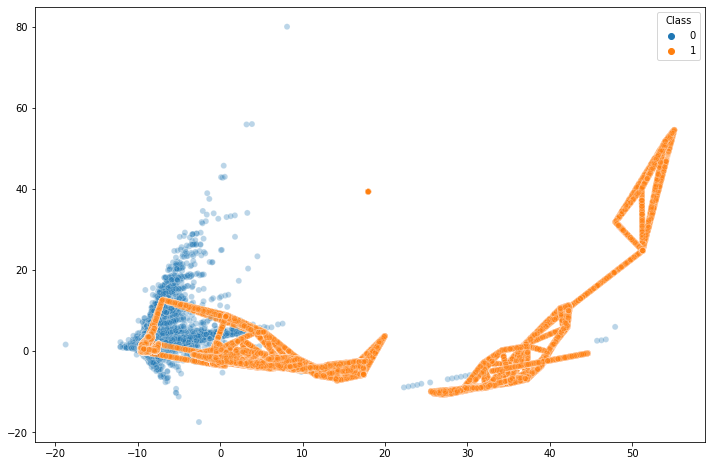

In [38]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x=X_reduced_PCA[:,0], y=X_reduced_PCA[:,1],
    hue="Class",
    data=sampled_df,
    legend="full",
    alpha=0.3
)

# 8.1 Modeling 

In order to solve the data leakage issue from applying oversampling before cross validation, use imblearn.pipeline to handle the case.

Sklearn.pipeline vs. imblearn.pipeline:
- imblearn.pipeline: Doesn't apply the oversample pipeline on validation data fold but only train folds.
- Sklearn.pipeline: Apply the whole pipeline to both validation data fold and train folds


The correct way to do so:

We should split into training and validation folds. Then, on each fold, we should

Oversample the minority class
Train the classifier on the training folds
Validate the classifier on the remaining fold

Reference:

[here](https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn/50245954?noredirect=1#comment103819811_50245954)
[here](https://stackoverflow.com/questions/49770851/customized-transformermixin-with-data-labels-in-sklearn/49771602#49771602)
[here](https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html)


### 8.1.1 Functions needed
1. Oversample by SMOTE during cross validation
2. Plot confusion matrix
3. Adjust threshold/decision boundary
4. ROC curve


In [42]:
def model_cv_search(X_train, y_train, X_test, y_test, model, randomCV_params, kf):
    #create pipeline
    # train_pipeline = pipeline([
    #     ('Scaler', scaler),
    #     ('sampling', SMOTE(sampling_strategy = 'minority')),
    #     ('classification', model)
    # ])

    train_pipeline = make_pipeline(SMOTE(sampling_strategy = 'minority'), model)
         
 
    #test on combinations of parameters over 5 folds for cross validation
    grid = GridSearchCV(train_pipeline, param_grid=randomCV_params, cv=kf, scoring='f1',
                        return_train_score=True)
    search = grid.fit(X_train.values,y_train.values)
    best_score = search.best_score_

    
    #get recall, precision, and f1 score from test
    y_test_predict = grid.predict(X_test.values)
    recall = recall_score(y_test, y_test_predict)
    precision = precision_score(y_test, y_test_predict)
    f1 = f1_score(y_test, y_test_predict)

    return grid, best_score, recall, precision, y_test_predict


In [43]:
#using the built-in plot_confusion_matrix cannot add a title  
#create my own plot_confusion_matrix2 function
def plot_confusion_matrix2(cm, classes,title):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    normalize = False
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
def adjust_threshold(thresholds,model,X_test, y_test):

    recall = []
    precision = []
    f1 = []
    for i in thresholds:
        y_pred_original_proba = model.predict_proba(X_test.values)
        y_test_predictions = y_pred_original_proba[:,1] > i
        cnf_matrix = confusion_matrix(y_test,y_test_predictions)

        #calculate recall, precision and f1
        recall_i = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
        precision_i = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
        f1_score_i = (2*recall_i*precision_i)/(recall_i+precision_i)
        recall.append(recall_i)
        precision.append(precision_i)
        f1.append(f1_score_i)


    threshold_result = pd.DataFrame({"Threshold": thresholds,
                                    "Recall": recall,
                                    "Precision": precision,
                                    "F1": f1})
    threshold_result.set_index('Threshold', inplace=True)
    threshold_result.plot.line()

    return threshold_result


Relationship between AUC ROC vs. other 'point' metrics (F1, recall/precision) [here](https://stackoverflow.com/questions/34698161/how-to-interpret-almost-perfect-accuracy-and-auc-roc-but-zero-f1-score-precisio)

In [45]:
def roc_curve_graph(X_test, y_test, model):
    
    #create chart canvas and sub plots
    plt.figure(figsize=(12,8))
    plt.title('ROC Curve', fontsize=18)
  
    #Difference between decision vs. predict_prob below
    #https://stats.stackexchange.com/questions/254710/is-it-better-to-compute-a-roc-curve-using-predicted-probabilities-or-distances-f
    #the output of predict_proba has two indexes with the first one referring the prob belong to class 0
    #while the second one referring the prob belong to class 1
    #here using the second one since it corresponds to decision_function
    if hasattr(model, "decision_function"):
        y_pred = model.decision_function(X_test.values)
        fpr, tpr, thresholds = roc_curve(y_test.values.ravel(),y_pred)
        roc_auc = auc(fpr,tpr)
    else: 
        y_pred = model.predict_proba(X_test.values)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test.values.ravel(),y_pred)
        roc_auc = auc(fpr,tpr)

    #auc() and roc_auc_score() output the same results if they use the same inputs
    model_label = "Classifier Score: {:.4f}".format(roc_auc_score(y_test, y_pred))
    plt.plot(fpr, tpr, label = model_label)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend(loc="best")


### 8.1.2 Logistic Regression


####Classification report and Confusion matrix 

The model has high recall but low precision, which means the model has large false positive (type I error) with lose criteria when predicting a fraud

In [42]:
kf = KFold(n_splits=5, random_state=42, shuffle=False)

#parameters for log_reg
params = { "penalty": ['l1', 'l2'],'C': [0.1, 1.0, 10]}
log_reg_params = {'logisticregression__' + key: params[key] for key in params}

log_reg = LogisticRegression()
log_best_estimator, log_best_score, log_recall, log_precision, log_y_pred = model_cv_search(X_train_original, y_train_original, X_test_original, y_test_original, log_reg, log_reg_params, kf)

In [44]:
log_recall

0.9183673469387755

In [45]:
log_precision

0.06108597285067873

In [46]:
log_best_score

0.11106733871488841

In [43]:
print(classification_report(y_test_original,log_y_pred, target_names=['No Fraud','Fraud']))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     85296
       Fraud       0.06      0.92      0.11       147

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.98      0.99     85443



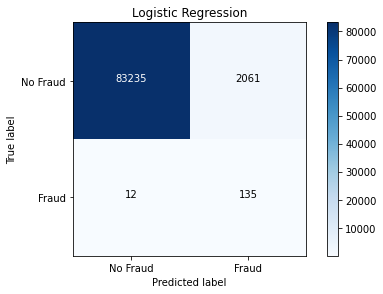

In [ ]:
cnf_matrix = confusion_matrix(y_test_original,log_y_pred)
class_name = ['No Fraud', 'Fraud']
model_title = 'Logistic Regression'
plot_confusion_matrix2(cnf_matrix, class_name, model_title)

####Determine the threshold

Shown earlier, the model has high recall but low precision, indicating a low threshold when predicting a fraud. Thus, by ploting the precision-recall pairs, we can determine a appropriate threshold

Text(0.5, 1.0, 'SMOTE Precision-Recall curve: \n Average Precision-Recall Score =0.76')

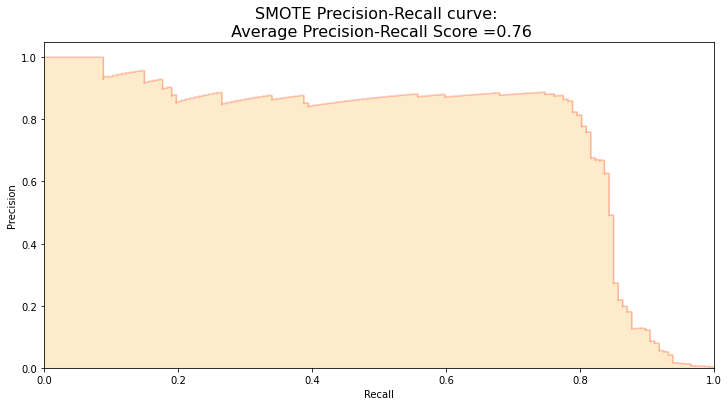

In [ ]:
#plot precision-recall pair for different probability threshold
y_score = log_best_estimator.decision_function(X_test_original)
average_precision = average_precision_score(y_test_original, y_score)

fig = plt.figure(figsize=(12,6))
precision, recall, _ = precision_recall_curve(y_test_original, y_score)
plt.step(recall, precision, color='r', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('SMOTE Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

,Recall,Precision,F1
Threshold,,,
0.1,0.965986,0.008423,0.016701
0.2,0.938776,0.018020,0.035362
0.3,0.938776,0.030430,0.058949
0.4,0.931973,0.045185,0.086191
0.5,0.918367,0.061475,0.115237
0.6,0.911565,0.082462,0.151242
0.7,0.904762,0.106999,0.191367
0.8,0.877551,0.146591,0.251217
0.9,0.863946,0.205502,0.332026


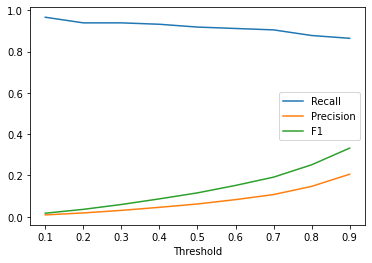

In [ ]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
model = log_best_estimator
adjust_threshold(thresholds,model, X_test_original,y_test_original)

####ROC curve

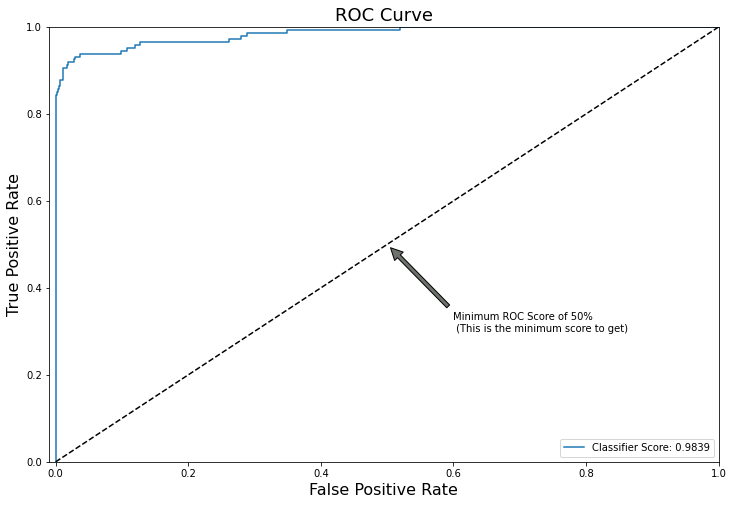

In [ ]:
roc_curve_graph(X_test_original, y_test_original,log_best_estimator)

### 8.1.3 Gaussian Naive Bayes 

#### Classification report and confusion matrix

In [47]:
kf = KFold(n_splits=5, random_state=42, shuffle=False)

#parameters for gnb
params = {'var_smoothing': [0.00000001, 0.000000001, 0.00000001]}
gnb_params = {'gaussiannb__' + key: params[key] for key in params}

gnb = GaussianNB()
gnb_estimator, gnb_best_score, gnb_recall, gnb_precision, gnb_y_pred = model_cv_search(X_train_original, y_train_original, X_test_original, y_test_original, gnb, gnb_params, kf)

In [48]:
gnb_precision

0.05719473445301861

In [49]:
gnb_recall

0.8571428571428571

In [50]:
gnb_best_score

0.10717573679283336

In [51]:
print(classification_report(y_test_original,gnb_y_pred, target_names=['No Fraud','Fraud']))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     85296
       Fraud       0.06      0.86      0.11       147

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.55     85443
weighted avg       1.00      0.98      0.99     85443



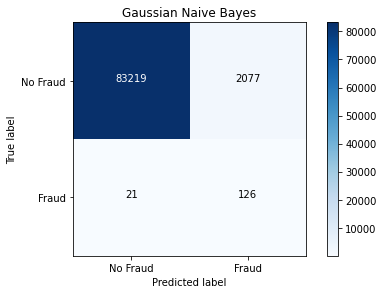

In [52]:
cnf_matrix = confusion_matrix(y_test_original,gnb_y_pred)
class_name = ['No Fraud', 'Fraud']
model_title = 'Gaussian Naive Bayes'
plot_confusion_matrix2(cnf_matrix, class_name, model_title)

####Determine the threshold

,Recall,Precision,F1
Threshold,,,
0.1,0.863946,0.053905,0.101478
0.2,0.863946,0.055386,0.104098
0.3,0.863946,0.056394,0.105877
0.4,0.863946,0.057336,0.107536
0.5,0.857143,0.057247,0.107325
0.6,0.857143,0.057958,0.108574
0.7,0.850340,0.058248,0.109027
0.8,0.850340,0.059326,0.110914
0.9,0.850340,0.060503,0.112969


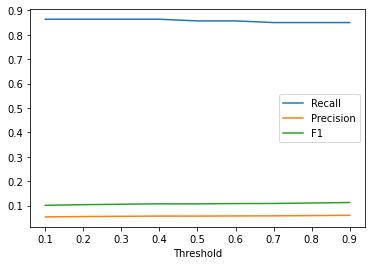

In [ ]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
model = gnb_estimator
adjust_threshold(thresholds,model, X_test_original,y_test_original)

#### ROC curve

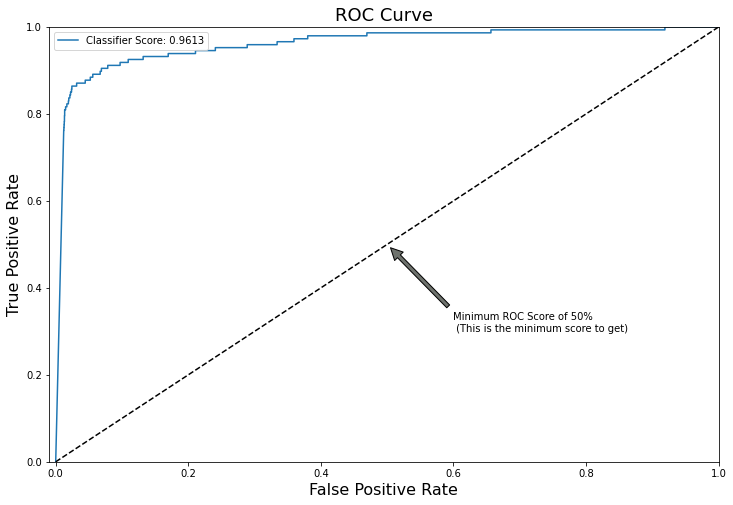

In [ ]:
roc_curve_graph(X_test_original, y_test_original,gnb_estimator)

### 8.1.4 KNN Classification

#### KNN Classifier - Classification report and confusion matrix

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=False)

#parameters for knn
params = {'n_neighbors': [3,6],
 'algorithm': ['ball_tree','kd_tree'],
 'leaf_size': [13]
    }
knn_params = {'kneighborsclassifier__' + key: params[key] for key in params}

knn= KNeighborsClassifier(n_neighbors = 5)
knn_best_estimator, knn_best_score, knn_recall, knn_precision, knn_y_pred = model_cv_search(X_train_original, y_train_original, X_test_original, y_test_original, knn, knn_params, kf)

KeyboardInterrupt: ignored

In [ ]:
print(classification_report(y_test_original,knn_y_pred, target_names=['No Fraud','Fraud']))

NameError: ignored

In [ ]:
cnf_matrix = confusion_matrix(y_test_original,knn_y_pred)
class_name = ['No Fraud', 'Fraud']
model_title = 'Logistic Regression'
plot_confusion_matrix2(cnf_matrix, class_name, model_title)

#### KNN Classifier - Determine threshold

In [ ]:
thresholds = [0.5,0.6,0.7,0.8,0.9]
model = knn_best_estimator
adjust_threshold(thresholds,model, X_test_original,y_test_original)

#### ROC curve

In [ ]:
roc_curve_graph(X_test_original, y_test_original,knn_best_estimator)

### 8.1.5 Random Forest Classification

####Classification report and confusion matrix

In [62]:
kf = KFold(n_splits=5, random_state=42, shuffle=False)

#parameters for rfc
params = {'n_estimators': [10,150],
 'max_depth': [4,7],
 'random_state': [13]
    }
rfc_params = {'randomforestclassifier__' + key: params[key] for key in params}

rfc= RandomForestClassifier()
rfc_best_estimator, rfc_best_score, rfc_recall, rfc_precision, rfc_y_pred = model_cv_search(X_train_original, y_train_original, X_test_original, y_test_original, rfc, rfc_params, kf)

In [65]:
rfc_best_estimator.best_params_

{'randomforestclassifier__max_depth': 7,
 'randomforestclassifier__n_estimators': 150,
 'randomforestclassifier__random_state': 13}

In [66]:
rfc_best_score

0.5092518775326853

In [67]:
rfc_recall

0.8435374149659864

In [68]:
rfc_precision

0.4217687074829932

In [63]:
print(classification_report(y_test_original,rfc_y_pred, target_names=['No Fraud','Fraud']))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     85296
       Fraud       0.42      0.84      0.56       147

    accuracy                           1.00     85443
   macro avg       0.71      0.92      0.78     85443
weighted avg       1.00      1.00      1.00     85443



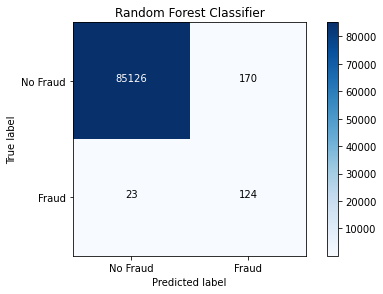

In [64]:
cnf_matrix = confusion_matrix(y_test_original,rfc_y_pred)
class_name = ['No Fraud', 'Fraud']
model_title = 'Random Forest Classifier'
plot_confusion_matrix2(cnf_matrix, class_name, model_title)

####Determine a threshold

,Recall,Precision,F1
Threshold,,,
0.1,0.965986,0.008800,0.017442
0.2,0.959184,0.031009,0.060077
0.3,0.891156,0.091544,0.166033
0.4,0.850340,0.217770,0.346741
0.5,0.843537,0.369048,0.513458
0.6,0.843537,0.551111,0.666667
0.7,0.823129,0.728916,0.773163
0.8,0.795918,0.841727,0.818182
0.9,0.734694,0.900000,0.808989


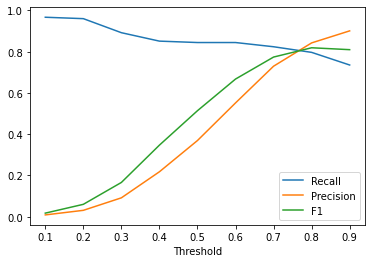

In [ ]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
model = rfc_best_estimator
adjust_threshold(thresholds,model, X_test_original, y_test_original)

#### ROC curve

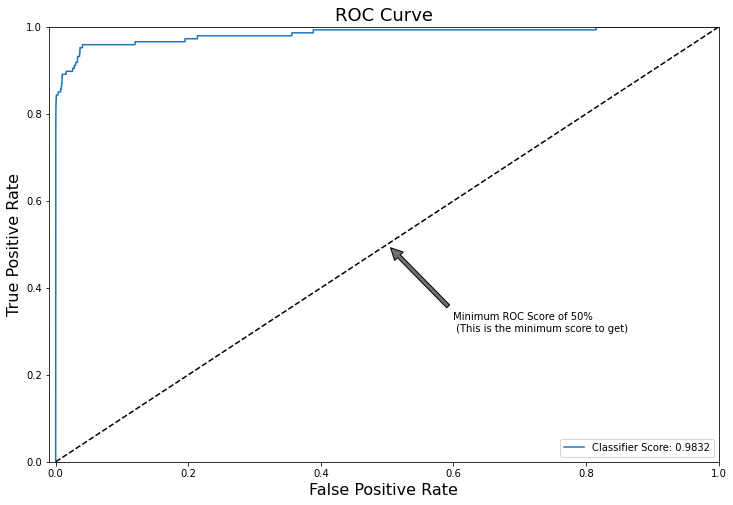

In [ ]:
roc_curve_graph(X_test_original, y_test_original,rfc_best_estimator)

### 8.1.6 Decision Tree Classification

#### Classification report and confusion matrix

In [53]:
kf = KFold(n_splits=5, random_state=42, shuffle=False)

#parameters for dtc
params = {'max_features': ['sqrt','log2'],
 'max_depth': [4,7],
 'random_state': [13]
    }
dtc_params = {'decisiontreeclassifier__' + key: params[key] for key in params}

dtc = DecisionTreeClassifier()
dtc_best_estimator, dtc_best_score, dtc_recall, dtc_precision, dtc_y_pred = model_cv_search(X_train_original, y_train_original, X_test_original, y_test_original, dtc, dtc_params, kf)

In [61]:
dtc_best_estimator.best_params_

{'decisiontreeclassifier__max_depth': 4,
 'decisiontreeclassifier__max_features': 'sqrt',
 'decisiontreeclassifier__random_state': 13}

In [54]:
dtc_best_score

0.16905752325957013

In [55]:
dtc_recall

0.8639455782312925

In [56]:
dtc_precision

0.06456532791052363

In [ ]:
print(classification_report(y_test_original,dtc_y_pred, target_names=['No Fraud','Fraud']))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     85296
       Fraud       0.07      0.86      0.12       147

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.56     85443
weighted avg       1.00      0.98      0.99     85443



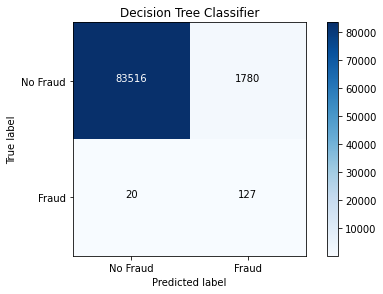

In [ ]:
cnf_matrix = confusion_matrix(y_test_original,dtc_y_pred)
class_name = ['No Fraud', 'Fraud']
model_title = 'Decision Tree Classifier'
plot_confusion_matrix2(cnf_matrix, class_name, model_title)

####Determine the threshold

,Recall,Precision,F1
Threshold,,,
0.5,0.863946,0.066597,0.123661
0.6,0.863946,0.066597,0.123661
0.7,0.843537,0.195893,0.317949
0.8,0.836735,0.232514,0.363905
0.9,0.836735,0.232514,0.363905


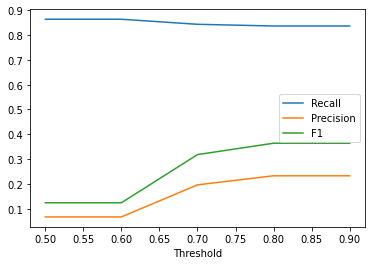

In [ ]:
thresholds = [0.5,0.6,0.7,0.8,0.9]
model = dtc_best_estimator
adjust_threshold(thresholds,model, X_test_original, y_test_original)

#### ROC Curve

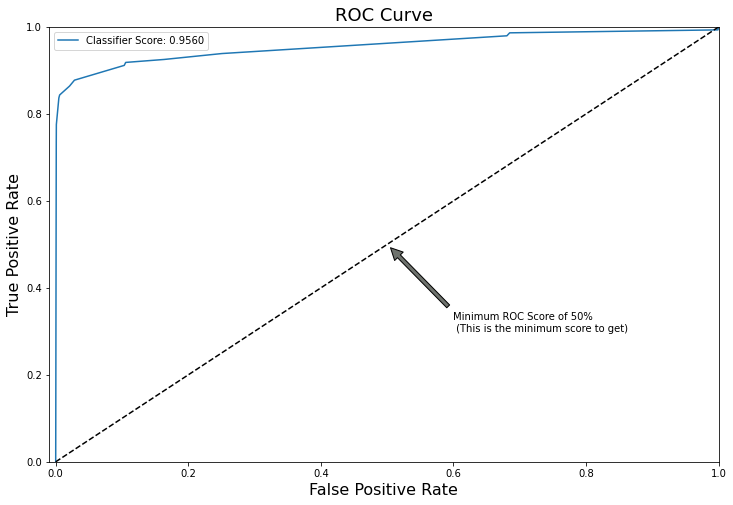

In [ ]:
roc_curve_graph(X_test_original, y_test_original,dtc_best_estimator)

###8.1.7 Gradient Boost Classification

#### Classification report and confusion matrix

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=False)

#parameters for gbc
params = {'n_estimators': [10,150],
 'max_depth': [4,7],
 'random_state': [13]
    }
gbc_params = {'gradientboostingclassifier__' + key: params[key] for key in params}

gbc = GradientBoostingClassifier()
gbc_best_estimator, gbc_best_score, gbc_recall, gbc_precision, gbc_y_pred = model_cv_search(X_train_original, y_train_original, X_test_original, y_test_original, gbc, gbc_params, kf)

In [ ]:
print(classification_report(y_test_original,gbc_y_pred, target_names=['No Fraud','Fraud']))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     85296
       Fraud       0.71      0.82      0.76       147

    accuracy                           1.00     85443
   macro avg       0.86      0.91      0.88     85443
weighted avg       1.00      1.00      1.00     85443



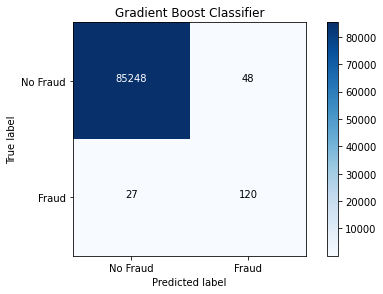

In [ ]:
cnf_matrix = confusion_matrix(y_test_original,gbc_y_pred)
class_name = ['No Fraud', 'Fraud']
model_title = 'Gradient Boost Classifier'
plot_confusion_matrix2(cnf_matrix, class_name, model_title)

####Determine the threshold

,Recall,Precision,F1
Threshold,,,
0.1,0.816327,0.404040,0.540541
0.2,0.816327,0.535714,0.646900
0.3,0.816327,0.634921,0.714286
0.4,0.816327,0.685714,0.745342
0.5,0.816327,0.714286,0.761905
0.6,0.816327,0.750000,0.781759
0.7,0.816327,0.784314,0.800000
0.8,0.816327,0.816327,0.816327
0.9,0.802721,0.874074,0.836879


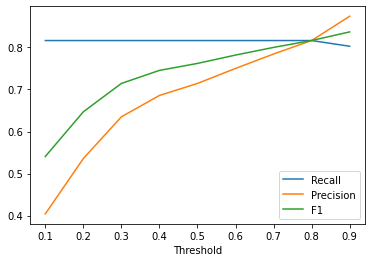

In [ ]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
model = gbc_best_estimator
adjust_threshold(thresholds,model, X_test_original,y_test_original)

#### ROC Curve

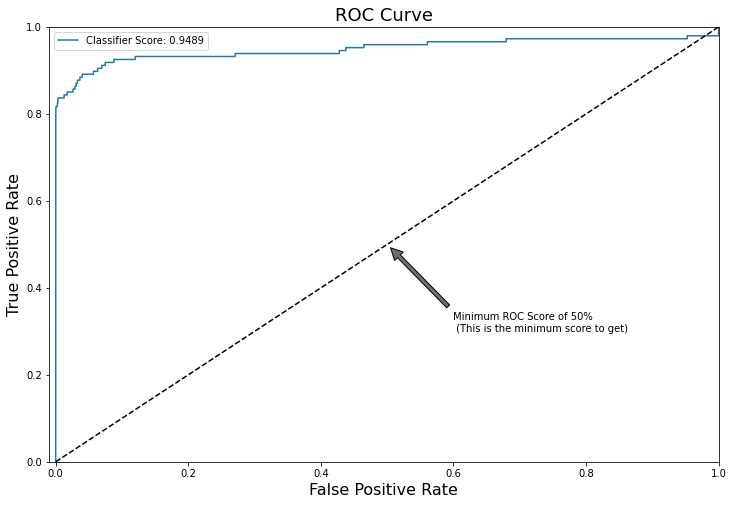

In [ ]:
roc_curve_graph(X_test_original, y_test_original,gbc_best_estimator)

### 8.1.8 LightGBM Classification

#### Classification report and confusion matrix

In [46]:
kf = KFold(n_splits=5, random_state=42, shuffle=False)

#parameters for xgb
params = {'max_depth': [10,20],
          'min_data_in_leaf': [13,20]
         }
lgb_params = {'lgbmclassifier__' + key: params[key] for key in params}

lgb = LGBMClassifier()
lgb_best_estimator, lgb_best_score, lgb_recall, lgb_precision, lgb_y_pred = model_cv_search(X_train_original, y_train_original, X_test_original, y_test_original, lgb, lgb_params, kf)

In [47]:
lgb.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [48]:
lgb_best_estimator.best_params_

{'lgbmclassifier__max_depth': 20, 'lgbmclassifier__min_data_in_leaf': 13}

In [49]:
lgb_best_score

0.7391876793358746

In [50]:
lgb_recall

0.8163265306122449

In [51]:
lgb_precision

0.631578947368421

In [53]:
print(classification_report(y_test_original,lgb_y_pred, target_names=['No Fraud','Fraud']))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     85296
       Fraud       0.63      0.82      0.71       147

    accuracy                           1.00     85443
   macro avg       0.82      0.91      0.86     85443
weighted avg       1.00      1.00      1.00     85443



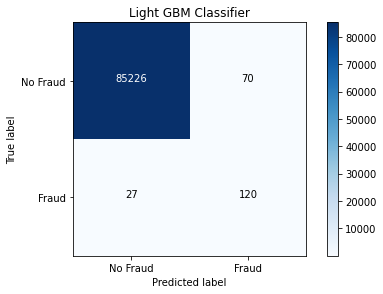

In [57]:
cnf_matrix = confusion_matrix(y_test_original,lgb_y_pred)
class_name = ['No Fraud', 'Fraud']
model_title = 'Light GBM Classifier'
plot_confusion_matrix2(cnf_matrix, class_name, model_title)

####Determine the threshold

,Recall,Precision,F1
Threshold,,,
0.1,0.843537,0.235741,0.368499
0.2,0.836735,0.383178,0.525641
0.3,0.823129,0.472656,0.600496
0.4,0.816327,0.545455,0.653951
0.5,0.816327,0.631579,0.712166
0.6,0.816327,0.710059,0.759494
0.7,0.809524,0.748428,0.777778
0.8,0.795918,0.790541,0.793220
0.9,0.782313,0.858209,0.818505


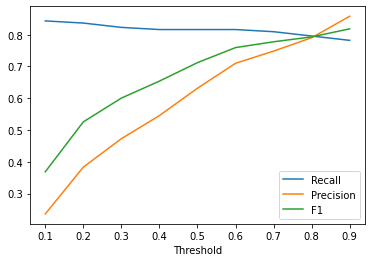

In [55]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
model = lgb_best_estimator
adjust_threshold(thresholds,model, X_test_original,y_test_original)

#### ROC curve

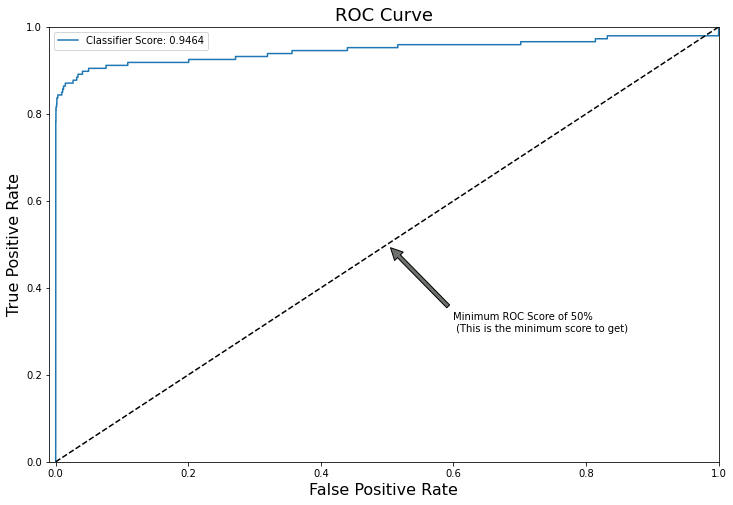

In [56]:
roc_curve_graph(X_test_original, y_test_original,lgb_best_estimator)

### 8.1.9 SVM

#### Classification report and confusion matrix

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=False)

#parameters for svc
params = {'kernal': ['linear','poly','sigmoid'],
 'C': [0.3,0.5,1],
 'random_state': [13]
    }
svc_params = {'svc__' + key: params[key] for key in params}

svc = SVC()
svc_best_estimator, svc_best_score, svc_recall, svc_precision, svc_y_pred = model_cv_search(X_train_original, y_train_original, X_test_original, y_test_original, svc, svc_params, kf)

In [ ]:
print(classification_report(y_test_original,svc_y_pred, target_names=['No Fraud','Fraud']))

In [ ]:
cnf_matrix = confusion_matrix(y_test_original,svc_y_pred)
class_name = ['No Fraud', 'Fraud']
model_title = 'Gradient Boost Classifier'
plot_confusion_matrix2(cnf_matrix, class_name, model_title)

#### Determine the threshold

In [ ]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
model = svc_best_estimator
adjust_threshold(thresholds,model, X_test_original,y_test_original)

#### ROC curve

In [ ]:
roc_curve_graph(X_test_original, y_test_original,svc_best_estimator)